In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os

import tensorflow as tf
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn import metrics

import wandb
from wandb.keras import WandbCallback

#custom packages
from models import createSimpleModel
from animate import *

In [2]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


Referencing: https://arxiv.org/pdf/2212.11285.pdf

We start off by loading in 1,000,000 background dijet events and 100,000 signal dijet events. The signal comes from the process Z$\rightarrow$ X($\rightarrow$ $q\bar{q}$) Y$\rightarrow$($q\bar{q}$) where Z is 3.5 TeV. X is 500 GeV and Y is 100 GeV. 

In [41]:
dir_path = "/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5"
df_test = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5")
df_test

,0,1,2,3,4,5,6,7,8,9,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,0.324101,-0.361158,2.737669,0.409859,-2.429939,0.729830,0.867922,-2.267777,-1.161310,0.383031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.646304,-0.539460,-1.386258,0.471293,-1.636572,0.751657,0.453769,-1.099593,-0.393405,0.485929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.325172,-0.833948,2.404844,1.295058,-2.089618,-1.873342,0.451272,-0.101877,2.217348,0.461293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.290918,-2.200063,1.630132,0.565028,-1.714345,-2.617103,0.951042,-0.532720,2.941473,0.896248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.526330,-2.349110,-1.745532,0.542491,-2.080352,-3.044045,0.390727,-1.278563,-2.131058,2.530358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099995,0.372368,-1.283898,2.680089,0.511526,-0.216247,1.011824,0.440795,-1.860590,1.395164,1.483386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099996,0.587996,-2.347485,0.104980,0.325682,-1.943584,-2.330028,0.700224,-2.161175,0.136797,0.550588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099997,0.631419,-0.597308,-2.114541,3.165008,-0.968924,-0.729551,4.613834,-0.989630,-0.724770,3.701483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099998,5.084272,-1.004487,1.772670,4.767743,-0.878143,1.713857,10.833469,-0.934815,1.795471,10.265807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
df_QCD

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1467.239990,611.502014,511.101990,38.896000,8.290650,4.836080,4.260190,1403.579956,-674.551025,-451.670990,237.893997,79.815102,21.010300,16.757601
1,-1211.239990,347.315002,547.963013,389.532013,191.804001,99.562798,70.872200,619.341003,-62.177299,-1944.040039,22.999201,8.042180,6.335090,5.525370
2,-1229.619995,649.857971,8.089170,72.155502,47.168098,37.243198,33.658199,1196.250000,-647.896973,-1283.109985,78.230698,15.292900,13.944200,10.013500
3,-693.304016,-1046.729980,1716.910034,55.797798,24.788500,6.890140,5.813400,747.961975,994.250000,-412.966003,359.113007,175.209000,103.500999,84.447098
4,-1488.199951,-25.370100,-30.989700,84.891502,26.878799,15.517200,13.260400,1415.640015,20.905100,223.630997,77.506500,57.986000,34.147400,26.660601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,-646.442017,-1295.150024,1331.800049,37.011299,21.006800,12.873700,8.898860,274.566986,1019.390015,-504.290985,90.375000,61.218800,20.514500,15.854600
999995,-286.550995,-1310.829956,-1510.910034,147.516998,60.997799,41.356201,28.225700,252.884995,1085.420044,759.314026,58.769901,42.276402,8.637120,7.852020
999996,918.562988,951.195984,-1622.569946,32.242199,5.894110,5.004100,3.992740,-266.285004,-1284.189941,185.007996,136.389008,70.623901,49.508499,40.708599
999997,1447.219971,-547.710999,827.945007,396.112000,181.406998,152.207993,86.676804,-932.369995,165.005005,-2806.959961,56.471600,14.446400,10.258900,8.874700


In [7]:
def computemjj_pd(event):
    px1 = np.array(event['pxj1'])
    py1 = np.array(event['pyj1'])
    pz1 = np.array(event['pzj1'])
    mj1 = np.array(event['mj1'])
    Ej1 = np.sqrt((px1**2 + py1**2 + pz1**2) + mj1**2)

    px2 = np.array(event['pxj2'])
    py2 = np.array(event['pyj2'])
    pz2 = np.array(event['pzj2'])
    mj2 = np.array(event['mj2'])
    Ej2 = np.sqrt((px2**2 + py2**2 + pz2**2) + mj2**2)

    p4_j1 = np.array([px1, py1, pz1, Ej1]).transpose()
    p4_j2 = np.array([px2, py2, pz2, Ej2]).transpose()
    
    p4_jj = p4_j1 + p4_j2
    mjj = np.sqrt((p4_jj**2 * np.array([-1, -1, -1, 1])).sum(axis=1))
    return mjj

In [9]:
mjj

array([3307.21938744, 3107.62060343, 3004.89527209, ..., 3021.08344341,
       4283.54500244, 2784.05801619])

In [15]:
df = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")

In [16]:
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1698.670044,-884.039978,723.843018,105.035004,83.721703,46.282101,13.635700,1539.439941,372.238007,-295.865997,461.574005,431.343994,52.344799,37.284901
1,1246.660034,-1133.010010,-921.987000,159.865997,133.781998,58.968601,30.377399,-1218.489990,1108.380005,182.147003,514.883972,462.654999,138.789001,67.805801
2,420.975006,-1739.790039,281.553986,93.665901,77.925797,10.605900,6.916520,-510.779999,1484.069946,227.175995,475.316986,217.113998,29.424000,21.020300
3,161.048996,-1664.859985,-2005.099976,116.327003,61.819698,38.143600,18.414400,-188.942993,1556.900024,-561.664001,561.236023,348.181000,102.625000,53.422699
4,-564.754028,-1315.599976,-1087.410034,513.015991,276.446991,50.629799,35.460999,326.164001,1050.239990,1201.000000,108.752998,89.666603,40.928699,17.055799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,-206.662003,-1729.280029,357.635010,96.165001,58.014500,11.731300,6.174070,218.800003,1714.890015,-210.578995,472.475006,259.884003,40.806999,31.226000
99995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.890999,21.177200,10.582400,9.138590
99996,-1286.619995,-86.162598,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502
99997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726601,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301


Text(0.5, 1.0, 'Jet Mass Distributions')

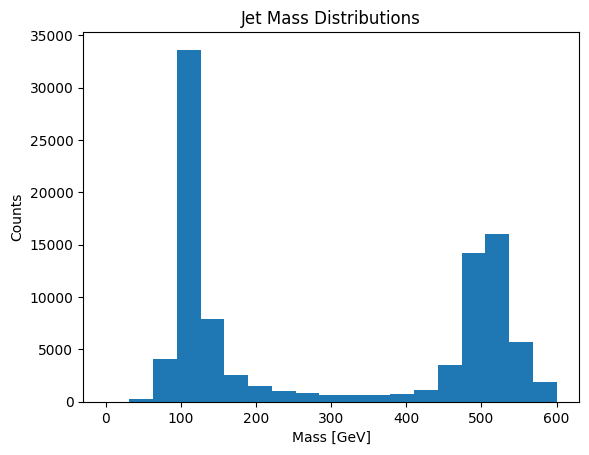

In [65]:
plt.hist(df['mj1'],bins=np.linspace(0,600,20))
plt.xlabel("Mass [GeV]")
plt.ylabel("Counts")
plt.title("Jet Mass Distributions")

In [112]:
# def computemjj_pd(event):
#     px1 = event[["pxj1"]].to_numpy()
#     py1 = event[["pyj1"]].to_numpy()
#     pz1 = event[["pzj1"]].to_numpy()
#     pE1 = np.sqrt(px1**2+py1**2+pz1**2+event[["mj1"]].to_numpy()**2)
    
#     px2 = event[["pxj2"]].to_numpy()
#     py2 = event[["pyj2"]].to_numpy()
#     pz2 = event[["pzj2"]].to_numpy()
#     pE2 = np.sqrt(px2**2+py2**2+pz2**2+event[["mj2"]].to_numpy()**2)
    
#     m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
#     return np.array(np.sqrt(m2)).flatten()

In [115]:
computemjj_pd(df_QCD)

/tmp/ipykernel_340405/3658239227.py:13: RuntimeWarning: invalid value encountered in sqrt
  return np.array(np.sqrt(m2)).flatten()


array([3355.02554618, 2339.42558763, 2476.53829533, ..., 3867.9955467 ,
       2882.70480346, 2279.14046694])

In [50]:
def computemjj_txt(event):
    pT1 = np.array([float(event[2*i][0]) for i in range(int(len(event)/2))])
    eta1 = np.array([float(event[2*i][1]) for i in range(int(len(event)/2))])
    phi1 = np.array([float(event[2*i][2]) for i in range(int(len(event)/2))])
    m1 = np.array([float(event[2*i][3]) for i in range(int(len(event)/2))])
    px1 = pT1*np.cos(phi1)
    py1 = pT1*np.sin(phi1)
    pz1 = pT1*np.sinh(eta1)
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+m1**2)
    
    pT2 = np.array([float(event[2*i+1][0]) for i in range(int(len(event)/2))])
    eta2 = np.array([float(event[2*i+1][1]) for i in range(int(len(event)/2))])
    phi2 = np.array([float(event[2*i+1][2]) for i in range(int(len(event)/2))])
    m2 = np.array([float(event[2*i+1][3]) for i in range(int(len(event)/2))])
    px2 = pT2*np.cos(phi2)
    py2 = pT2*np.sin(phi2)
    pz2 = pT2*np.sinh(eta2)
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+m2**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [3]:
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]

epsilon = 1e-6
if (False):
    lmass_vec = {}
    x = {}
    mjjs = {}

    mu_m = 0.
    mu_t = 0.
    sd_m = 0.
    sd_t = 0.

    for m1 in mass_range:
        for m2 in mass_range:

            print("on ...",m1,m2)

            ltau1_m_m = []
            ltau2_m_m = []
            stau1_m_m = []
            stau2_m_m = []
            if (m1>0 and m2>0):
                myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                jets_m_m = []
                for line in myfile:
                    jets_m_m+=[line.split("J")[1].split("P")[0].split()]
                    pass
                                    
                ljet_m_m = [jets_m_m[2*n] for n in range(int(len(jets_m_m)/2))]
                sjet_m_m = [jets_m_m[2*n+1] for n in range(int(len(jets_m_m)/2))]

                lmass_m_m = np.array([float(ljet_m_m[i][3]) for i in range(len(ljet_m_m))])/1000.
                smass_m_m = np.array([float(sjet_m_m[i][3]) for i in range(len(sjet_m_m))])/1000.

                #check ordering of the leading and subleading jets
                #if leading jet mm > subleading, continue
                #if leading jet mm < subleading, swap
                for i in range(int(len(lmass_m_m))):
                    if lmass_m_m[i] > smass_m_m[i]:
                        continue
                    elif lmass_m_m[i] < smass_m_m[i]:
                        lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]
                
                ltau1_m_m = np.array([float(ljet_m_m[i][5]) for i in range(len(ljet_m_m))])
                ltau2_m_m = np.array([float(ljet_m_m[i][6]) for i in range(len(ljet_m_m))])

                stau1_m_m = np.array([float(sjet_m_m[i][5]) for i in range(len(ljet_m_m))])
                stau2_m_m = np.array([float(sjet_m_m[i][6]) for i in range(len(ljet_m_m))])

                mjj = computemjj_txt(jets_m_m)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]
                pass
            elif m1==0 and m2==0:
                df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
                lmass_m_m = np.array(df_QCD[["mj1"]]).flatten()/1000.
                smass_m_m = np.array(df_QCD[["mj2"]]).flatten()/1000.
                
                #check jet ordering
                for i in range(int(len(lmass_m_m))):
                    if lmass_m_m[i] > smass_m_m[i]:
                        continue
                    elif lmass_m_m[i] < smass_m_m[i]:
                        lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]
                        
                ltau1_m_m = np.array(df_QCD[["tau1j1"]]).flatten()
                ltau2_m_m = np.array(df_QCD[["tau2j1"]]).flatten()
                stau1_m_m = np.array(df_QCD[["tau1j2"]]).flatten()
                stau2_m_m = np.array(df_QCD[["tau2j2"]]).flatten()
                mjj = computemjj_pd(df_QCD)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]

                mu_m = np.mean(lmass_m_m)
                mu_t = np.mean(ltau2_m_m/(ltau1_m_m+epsilon))
                sd_m = np.std(lmass_m_m)
                sd_t = np.std(ltau2_m_m/(ltau1_m_m+epsilon))
                pass
            else:
                continue

            ms = np.stack([lmass_m_m,smass_m_m],axis=1)
            ts = np.stack([ltau2_m_m/(ltau1_m_m+epsilon),stau2_m_m/(stau1_m_m+epsilon)],axis=1)
            order1 = [np.argmax(ms[i]) for i in range(len(ms))]
            order2 = [np.argmin(ms[i]) for i in range(len(ms))]
            mJ1 = np.array([ms[i][order1[i]] for i in range(len(ms))])
            mJ2 = np.array([ms[i][order2[i]] for i in range(len(ms))])
            x[m1,m2] = np.stack([(mJ2 - mu_m)/sd_m,
                                    ((mJ1 - mJ2) - mu_m)/sd_m,
                                    ([ts[i][order2[i]] for i in range(len(ts))] - mu_t)/sd_t,
                                    ([ts[i][order1[i]] for i in range(len(ts))] - mu_t)/sd_t],axis=1)
            lmass_vec[m1,m2]=lmass_m_m
            pass
        pass

    x_array = []
    for m1 in mass_range:
        for m2 in mass_range:
            if (m1==0 and m2>0 or m2==0 and m1>0):
                continue
            x_array+=[x[m1,m2]]
    np.save("x_array_order1", x_array)

In [4]:
x = {}
x_array_read = np.load("x_array_order.npy",allow_pickle=True)
mycounter = -1
for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
    for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        if (m1==0 and m2>0 or m2==0 and m1>0):
            continue
        mycounter+=1
        x[m1,m2] = x_array_read[mycounter]

In [5]:
np.shape(x[0,0])

(121352, 4)

In [6]:
x_data_100 = np.concatenate([x[0,0],x[1,1]])
y_data_100 = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[1,1]))])
X_train_100, X_val_100, Y_train_100, Y_val_100 = train_test_split(x_data_100, y_data_100, test_size=0.5)

In [48]:
pscratch_dir = "/pscratch/sd/g/gupsingh"
os.environ["WANDB_DIR"] = pscratch_dir

wandb.init(
    project="Anomaly",
    group="Dedicated_Fixed",
    entity='gup-singh',
    mode = 'online',

    config={
        "layer_1": 512,
        "activation_1": "relu",
        "layer_2": 256,
        "activation_2": "relu",
        "layer_3": 128,
        "activation_3": "relu",
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 1000,
        "batch_size": 1024,
    },
    dir=pscratch_dir
)

config = wandb.config

In [49]:
model_dedicated = Sequential()
model_dedicated.add(Dense(config.layer_1, input_dim=4, activation=config.activation_1))
#model_dedicated.add(Dropout(config.dropout_rate_1))
model_dedicated.add(Dense(config.layer_2, activation=config.activation_2))
model_dedicated.add(Dense(config.layer_3, activation=config.activation_3))
model_dedicated.add(Dense(config.output_layer, activation=config.output_activation))
model_dedicated.compile(loss=config.loss, optimizer=config.optimizer, metrics=[config.metric])
model_dedicated.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 512)               2560      
                                                                 
 dense_29 (Dense)            (None, 256)               131328    
                                                                 
 dense_30 (Dense)            (None, 128)               32896     
                                                                 
 dense_31 (Dense)            (None, 1)                 129       
                                                                 
Total params: 166,913
Trainable params: 166,913
Non-trainable params: 0
_________________________________________________________________


In [50]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [51]:
myhistory = model_dedicated.fit(X_train_100, Y_train_100, epochs=config.epoch,
                                validation_data=(X_val_100, Y_val_100),
                                batch_size=config.batch_size, callbacks=[WandbCallback(), es])

Epoch 1/1000
68/97 [====================>.........] - ETA: 0s - loss: 0.1063 - accuracy: 0.8560INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 10ms/step - loss: 0.0997 - accuracy: 0.8657 - val_loss: 0.0822 - val_accuracy: 0.8896
Epoch 2/1000
66/97 [===================>..........] - ETA: 0s - loss: 0.0794 - accuracy: 0.8944INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 9ms/step - loss: 0.0782 - accuracy: 0.8952 - val_loss: 0.0737 - val_accuracy: 0.9015
Epoch 3/1000
88/97 [==========================>...] - ETA: 0s - loss: 0.0689 - accuracy: 0.9063INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 9ms/step - loss: 0.0689 - accuracy: 0.9061 - val_loss: 0.0644 - val_accuracy: 0.9111
Epoch 4/1000
66/97 [===================>..........] - ETA: 0s - loss: 0.0650 - accuracy: 0.9105INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 9ms/step - loss: 0.0638 - accuracy: 0.9123 - val_loss: 0.0608 - val_accuracy: 0.9160
Epoch 5/1000
67/97 [===================>..........] - ETA: 0s - loss: 0.0620 - accuracy: 0.9151INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 9ms/step - loss: 0.0619 - accuracy: 0.9148 - val_loss: 0.0604 - val_accuracy: 0.9166
Epoch 6/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0619 - accuracy: 0.9143 - val_loss: 0.0614 - val_accuracy: 0.9147
Epoch 7/1000
65/97 [===================>..........] - ETA: 0s - loss: 0.0613 - accuracy: 0.9151INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 9ms/step - loss: 0.0615 - accuracy: 0.9151 - val_loss: 0.0598 - val_accuracy: 0.9168
Epoch 8/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0611 - accuracy: 0.9157 - val_loss: 0.0619 - val_accuracy: 0.9138
Epoch 9/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0611 - accuracy: 0.9156 - val_loss: 0.0602 - val_accuracy: 0.9161
Epoch 10/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0616 - accuracy: 0.9151 - val_loss: 0.0610 - val_accuracy: 0.9161
Epoch 11/1000
93/97 [===========================>..] - ETA: 0s - loss: 0.0609 - accuracy: 0.9155INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 9ms/step - loss: 0.0609 - accuracy: 0.9155 - val_loss: 0.0597 - val_accuracy: 0.9174
Epoch 12/1000
66/97 [===================>..........] - ETA: 0s - loss: 0.0615 - accuracy: 0.9147INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 13ms/step - loss: 0.0606 - accuracy: 0.9162 - val_loss: 0.0595 - val_accuracy: 0.9177
Epoch 13/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0609 - accuracy: 0.9157 - val_loss: 0.0596 - val_accuracy: 0.9174
Epoch 14/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0607 - accuracy: 0.9163 - val_loss: 0.0601 - val_accuracy: 0.9168
Epoch 15/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0605 - accuracy: 0.9163 - val_loss: 0.0600 - val_accuracy: 0.9168
Epoch 16/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0609 - accuracy: 0.9156 - val_loss: 0.0601 - val_accuracy: 0.9168
Epoch 17/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0605 - accuracy: 0.9161 - val_loss: 0.0606 - val_accuracy: 0.9158
Epoch 18/1000
88/97 [==========================>...] - ETA: 0s - loss: 0.0609 - accuracy: 0.9153INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/

wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 10ms/step - loss: 0.0608 - accuracy: 0.9156 - val_loss: 0.0594 - val_accuracy: 0.9175
Epoch 19/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0607 - accuracy: 0.9165 - val_loss: 0.0601 - val_accuracy: 0.9165
Epoch 20/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0604 - accuracy: 0.9166 - val_loss: 0.0597 - val_accuracy: 0.9174
Epoch 21/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0604 - accuracy: 0.9162 - val_loss: 0.0598 - val_accuracy: 0.9173
Epoch 22/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0603 - accuracy: 0.9166 - val_loss: 0.0606 - val_accuracy: 0.9157
Epoch 23/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0604 - accuracy: 0.9163 - val_loss: 0.0601 - val_accuracy: 0.9167
Epoch 24/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0601 - accuracy: 0.9167 - val_loss: 0.0596 - val_accuracy: 0.9173
Epoch 25/100

In [52]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▅▆▇████████████████████████
epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆██▇█▇█████████████▇██████
val_loss,█▅▃▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.91676
best_epoch,17
best_val_loss,0.05944
epoch,27
loss,0.06022
val_accuracy,0.91689


In [7]:
model_dedicated = Sequential()
model_dedicated.add(Dense(128, input_dim=4, activation='relu'))
model_dedicated.add(Dense(128, activation='relu'))
model_dedicated.add(Dense(128, activation='relu'))
model_dedicated.add(Dense(1, activation='sigmoid'))
model_dedicated.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

2023-11-15 14:26:47.851303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 14:26:48.528032: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12293 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [9]:
myhistory = model_dedicated.fit(X_train_100, Y_train_100, epochs=100,validation_data=(X_val_100, Y_val_100),batch_size=1024)

Epoch 1/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1931 - accuracy: 0.9190 - val_loss: 0.1905 - val_accuracy: 0.9201
Epoch 2/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1921 - accuracy: 0.9194 - val_loss: 0.1890 - val_accuracy: 0.9206
Epoch 3/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1920 - accuracy: 0.9198 - val_loss: 0.1891 - val_accuracy: 0.9208
Epoch 4/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1929 - accuracy: 0.9191 - val_loss: 0.1888 - val_accuracy: 0.9213
Epoch 5/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1918 - accuracy: 0.9199 - val_loss: 0.1884 - val_accuracy: 0.9211
Epoch 6/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1925 - accuracy: 0.9190 - val_loss: 0.1893 - val_accuracy: 0.9207
Epoch 7/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1919 - accuracy: 0.9195 - val_loss: 0.1883 - val_accuracy: 0.9206

In [34]:
wandb.finish()

In [53]:
#model_dedicated.save("model_100_BCE")
#model.save("model_MSE")

INFO:tensorflow:Assets written to: model_100_BCE/assets


In [59]:
preds_mm_list = []

tuple_rates_dedicated_ordered_BCE = {}

for i in mass_range[1:]:
    for j in mass_range[1:]:
        if (i == 0.5 and j == 0.5) or (i == 1 and j == 1) or (i == 3 and j == 3) or (i == 6 and j == 6):
            print(i,j)
            x_vals_mm = np.concatenate([x[0,0],x[i,j]])
            y_vals_mm = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[i,j]))])
            X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(x_vals_mm, y_vals_mm, test_size=0.5)

            model = Sequential()
            model.add(Dense(512, input_dim=4, activation='relu'))
            model.add(Dense(256, activation='relu'))
            model.add(Dense(128, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

            myhistory = model.fit(X_train_mm, Y_train_mm, epochs=1000, validation_data=(X_val_mm, Y_val_mm),batch_size=1024, callbacks = [es])

            preds_mm = model.predict(X_val_mm,batch_size=1000)
            fpr_mm, tpr_mm, _ = metrics.roc_curve(Y_val_mm, preds_mm)

            preds_mm_list.append(preds_mm)
            tuple_rates_dedicated_BCE[tuple((i, j))] = [fpr_mm, tpr_mm]

0.5 0.5
Epoch 1/1000
192/192 [==============================] - 2s 6ms/step - loss: 0.2920 - accuracy: 0.8740 - val_loss: 0.2710 - val_accuracy: 0.8852
Epoch 2/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2666 - accuracy: 0.8874 - val_loss: 0.2613 - val_accuracy: 0.8931
Epoch 3/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2588 - accuracy: 0.8922 - val_loss: 0.2572 - val_accuracy: 0.8919
Epoch 4/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2567 - accuracy: 0.8930 - val_loss: 0.2545 - val_accuracy: 0.8939
Epoch 5/1000
192/192 [==============================] - 1s 6ms/step - loss: 0.2557 - accuracy: 0.8927 - val_loss: 0.2544 - val_accuracy: 0.8944
Epoch 6/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2555 - accuracy: 0.8927 - val_loss: 0.2522 - val_accuracy: 0.8950
Epoch 7/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2553 - accuracy: 0.8933 - val_loss: 0.2530 - val_a

In [60]:
len(tuple_rates_dedicated_BCE_Optimized)

4

In [61]:
# np.save("fpr_mm", fpr_mm_list)
# np.save("tpr_mm", tpr_mm_list)
np.save("tuple_rates_dedicated_BCE", tuple_rates_dedicated_BCE)

#fpr_mm_list = np.load("fpr_mm.npy", allow_pickle = True)

In [62]:
model_all_BCE = tf.keras.models.load_model('model_all_BCE')

In [114]:
tuple_rates_dedicated = np.load("tuple_rates_dedicated.npy", allow_pickle = True).item()
len(tuple_rates_dedicated)

144

In [65]:
preds_all_BCE_50 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[0.5,0.5],axis=1)==1],batch_size=1000)
fpr_all_BCE_50, tpr_all_BCE_50, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[0.5,0.5],axis=1)==1], preds_all_BCE_50)

99/99 [==============================] - 0s 756us/step


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


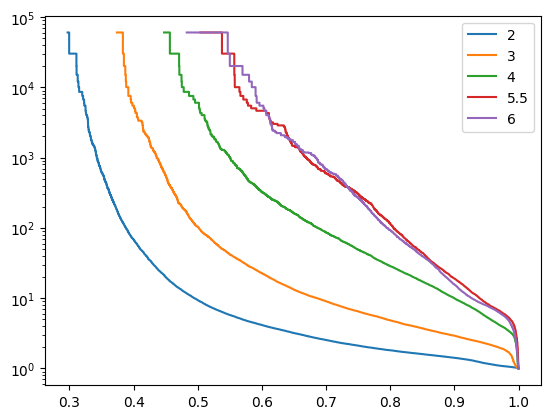

In [181]:
for m in [2, 3, 4, 5.5, 6]:
    something = X_val_all[np.product(X_val_all[:,4:6]==[4.5,6],axis=1)==1]
    something[:,4:6]= np.c_[np.ones(len(something)) * m, np.ones(len(something)) * m]
    preds_all_BCE_50 = model_all_BCE.predict(something,batch_size=1000)
    fpr_all_BCE_50, tpr_all_BCE_50, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[4.5,6],axis=1)==1], preds_all_BCE_50)
    plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))
    plt.legend()
    plt.yscale("log")

In [174]:
np.shape(np.c_[np.ones(len(something)) * 3, np.ones(len(something)) * 3])

(98560, 2)

In [172]:
np.shape(something[:,4:6])

(98560, 2)

In [63]:
preds_all_BCE_100 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
fpr_all_BCE_100, tpr_all_BCE_100, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_BCE_100)

preds_all_BCE_200 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[2,2],axis=1)==1],batch_size=1000)
fpr_all_BCE_200, tpr_all_BCE_200, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[2,2],axis=1)==1], preds_all_BCE_200)

preds_all_BCE_300 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[3,3],axis=1)==1],batch_size=1000)
fpr_all_BCE_300, tpr_all_BCE_300, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[3,3],axis=1)==1], preds_all_BCE_300)

preds_all_BCE_400 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[4,4],axis=1)==1],batch_size=1000)
fpr_all_BCE_400, tpr_all_BCE_400, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[4,4],axis=1)==1], preds_all_BCE_400)

preds_all_BCE_500 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[5,5],axis=1)==1],batch_size=1000)
fpr_all_BCE_500, tpr_all_BCE_500, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[5,5],axis=1)==1], preds_all_BCE_500)

preds_all_BCE_600 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[6,6],axis=1)==1],batch_size=1000)
fpr_all_BCE_600, tpr_all_BCE_600, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[6,6],axis=1)==1], preds_all_BCE_600)

87/87 [==============================] - 0s 757us/step


In [64]:
tuple_rates_dedicated_BCE_Optimized.keys()

dict_keys([(0.5, 0.5), (1, 1), (3, 3), (6, 6)])

Text(0.5, 1.0, '$(600,600)$ GeV Dedicated vs Parametrized BCE')

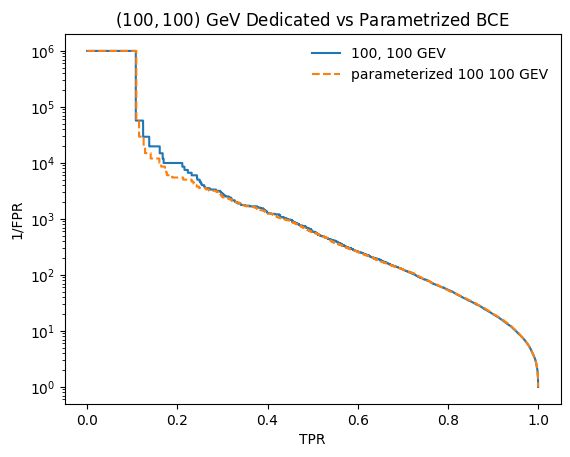

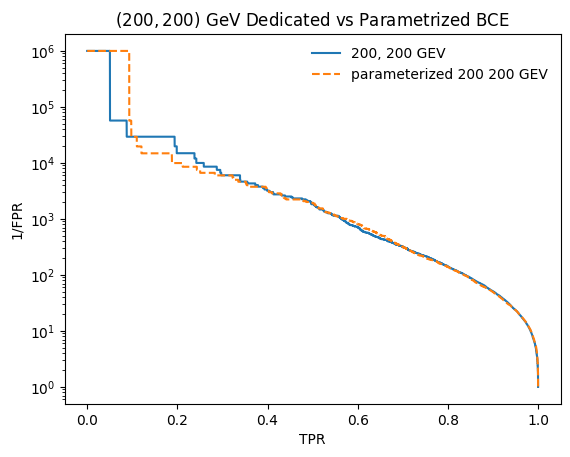

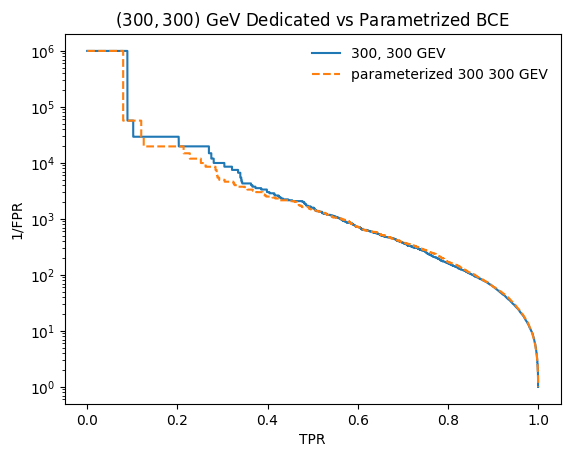

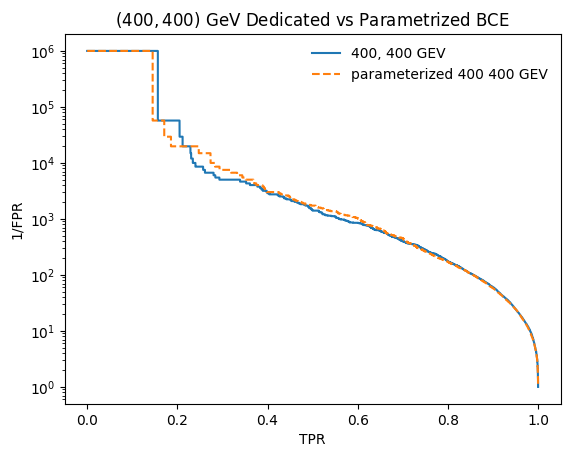

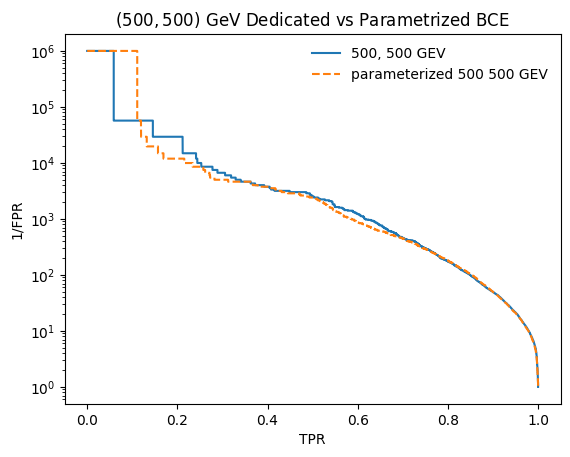

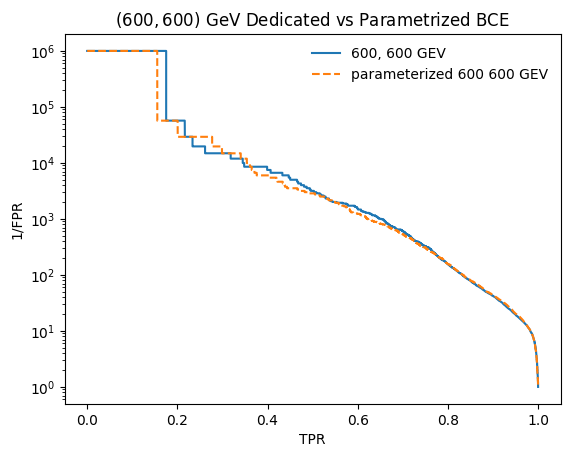

In [116]:
epsilon = 1e-6
plt.figure()
plt.plot(tuple_rates_dedicated[(1,1)][1], 1./(tuple_rates_dedicated[(1,1)][0] + epsilon), label = "100, 100 GEV")
plt.plot(tpr_all_BCE_100, 1./(fpr_all_BCE_100 + epsilon),label="parameterized 100 100 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(100,100)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(2,2)][1], 1./(tuple_rates_dedicated[(2,2)][0] + epsilon), label = "200, 200 GEV")
plt.plot(tpr_all_BCE_200, 1./(fpr_all_BCE_200 + epsilon),label="parameterized 200 200 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(200,200)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(3,3)][1], 1./(tuple_rates_dedicated[(3,3)][0] + epsilon), label = "300, 300 GEV")
plt.plot(tpr_all_BCE_300, 1./(fpr_all_BCE_300 + epsilon),label="parameterized 300 300 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(300,300)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(4,4)][1], 1./(tuple_rates_dedicated[(4,4)][0] + epsilon), label = "400, 400 GEV")
plt.plot(tpr_all_BCE_400, 1./(fpr_all_BCE_400 + epsilon),label="parameterized 400 400 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(400,400)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(5,5)][1], 1./(tuple_rates_dedicated[(5,5)][0] + epsilon), label = "500, 500 GEV")
plt.plot(tpr_all_BCE_500, 1./(fpr_all_BCE_500 + epsilon),label="parameterized 500 500 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(500,500)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(6,6)][1], 1./(tuple_rates_dedicated[(6,6)][0] + epsilon), label = "600, 600 GEV")
plt.plot(tpr_all_BCE_600, 1./(fpr_all_BCE_600 + epsilon),label="parameterized 600 600 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(600,600)$ GeV Dedicated vs Parametrized BCE")

Analysis of Models begins here

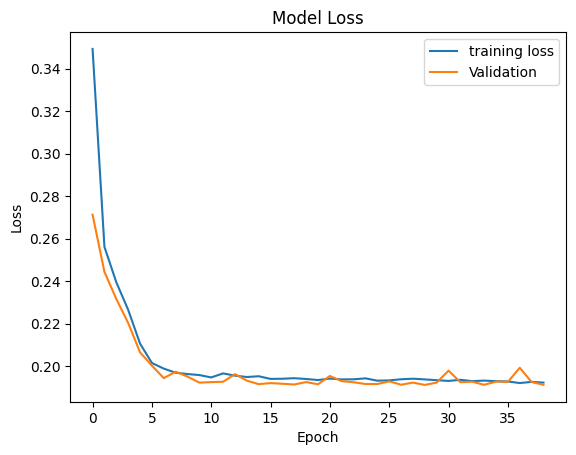

In [153]:
# Plot the training and validation loss
plt.plot(myhistory.history['loss'])
plt.plot(myhistory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss', 'Validation'], loc='upper right')
plt.show()

In [89]:
preds_100 = model.predict(X_val_100,batch_size=1000)
fpr_100, tpr_100, _ = metrics.roc_curve(Y_val_100, preds_100)

99/99 [==============================] - 0s 737us/step


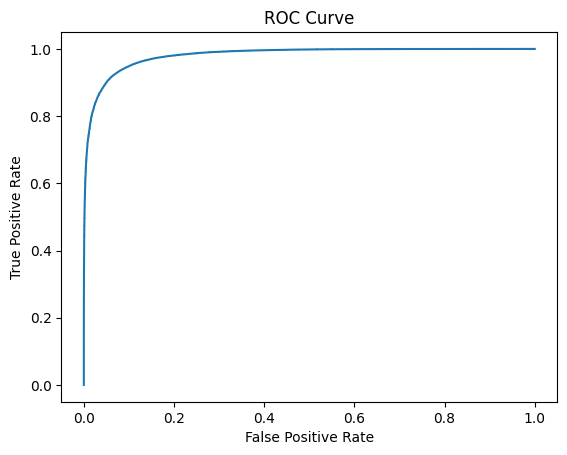

In [79]:
plt.plot(1-tpr_100, 1-fpr_100)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [13]:
if (False):
    x_vals_all = []
    y_vals_all = []
    for m1 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            print(m1,m2)
            x_aug_0 = np.append(np.append(x[0,0],m1*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1),m2*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1)
            x_aug_m = np.append(np.append(x[m1,m2],m1*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1)
            if (m1==0.5 and m2==0.5):
                x_vals_all = np.concatenate([x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
            else:
                x_vals_all = np.concatenate([x_vals_all,x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([y_vals_all,np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
    np.save("x_vals_all_fixed",x_vals_all)
    np.save("y_vals_all_fixed",y_vals_all)

In [7]:
x_vals_all = np.load("x_vals_all_fixed.npy")
y_vals_all = np.load("y_vals_all_fixed.npy")

In [8]:
np.shape(x_vals_all)

(27249420, 6)

In [9]:
X_train_all, X_val_all, Y_train_all, Y_val_all = train_test_split(x_vals_all, y_vals_all, test_size=0.5)

In [18]:
pscratch_dir = "/pscratch/sd/g/gupsingh"
os.environ["WANDB_DIR"] = pscratch_dir

wandb.init(
    project="Anomaly",
    group="Parametrized_Fixed",
    entity='gup-singh',
    mode = 'online',

    config={
        "layer_1": 128,
        "activation_1": "relu",
        "layer_2": 128,
        "activation_2": "relu",
        "layer_3": 128,
        "activation_3": "relu",
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 1000,
        "batch_size": 1024
    },
    dir = pscratch_dir
)

config_parametrized = wandb.config

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▇▇▇███████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇▇▇▆▇▆█▆█▇▇██
val_loss,█▃▂▂▂▃▂▂▁▂▁▂▂▁▁
accuracy,0.9339
best_epoch,14
best_val_loss,0.16763
epoch,14
loss,0.16797
val_accuracy,0.934


In [19]:
model_all = Sequential()
model_all.add(Dense(config_parametrized.layer_1, input_dim=6, activation=config_parametrized.activation_1))
model_all.add(Dense(config_parametrized.layer_2, activation=config_parametrized.activation_2))
model_all.add(Dense(config_parametrized.layer_3, activation=config_parametrized.activation_3))
model_all.add(Dense(config_parametrized.output_layer, activation=config_parametrized.output_activation))
model_all.compile(loss=config_parametrized.loss, optimizer=config_parametrized.optimizer, metrics=['accuracy'])

In [20]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [21]:
with tf.device('/GPU:0'):
    myhistory_all = model_all.fit(X_train_all, Y_train_all, epochs=config_parametrized.epoch,validation_data=(X_val_all, Y_val_all),batch_size=config_parametrized.batch_size*5, callbacks = [WandbCallback(), es])

Epoch 1/1000
2657/2662 [============================>.] - ETA: 0s - loss: 0.1962 - accuracy: 0.9227INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best)... Done. 0.1s


2662/2662 [==============================] - 7s 2ms/step - loss: 0.1962 - accuracy: 0.9227 - val_loss: 0.1780 - val_accuracy: 0.9303
Epoch 2/1000
2659/2662 [============================>.] - ETA: 0s - loss: 0.1734 - accuracy: 0.9320INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 6s 2ms/step - loss: 0.1734 - accuracy: 0.9320 - val_loss: 0.1711 - val_accuracy: 0.9329
Epoch 3/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1712 - accuracy: 0.9327 - val_loss: 0.1736 - val_accuracy: 0.9314
Epoch 4/1000
2645/2662 [============================>.] - ETA: 0s - loss: 0.1704 - accuracy: 0.9330INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 7s 2ms/step - loss: 0.1703 - accuracy: 0.9330 - val_loss: 0.1698 - val_accuracy: 0.9331
Epoch 5/1000
2645/2662 [============================>.] - ETA: 0s - loss: 0.1698 - accuracy: 0.9332INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 6s 2ms/step - loss: 0.1698 - accuracy: 0.9332 - val_loss: 0.1695 - val_accuracy: 0.9332
Epoch 6/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1694 - accuracy: 0.9334 - val_loss: 0.1699 - val_accuracy: 0.9332
Epoch 7/1000
2641/2662 [============================>.] - ETA: 0s - loss: 0.1691 - accuracy: 0.9335INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 7s 2ms/step - loss: 0.1691 - accuracy: 0.9335 - val_loss: 0.1689 - val_accuracy: 0.9337
Epoch 8/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1689 - accuracy: 0.9335 - val_loss: 0.1691 - val_accuracy: 0.9334
Epoch 9/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1687 - accuracy: 0.9335 - val_loss: 0.1693 - val_accuracy: 0.9334
Epoch 10/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1686 - accuracy: 0.9336 - val_loss: 0.1722 - val_accuracy: 0.9322
Epoch 11/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1684 - accuracy: 0.9337 - val_loss: 0.1693 - val_accuracy: 0.9334
Epoch 12/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1683 - accuracy: 0.9338 - val_loss: 0.1689 - val_accuracy: 0.9335


In [22]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▇▇▇████████
epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▆▃▇▇▇█▇▇▅▇█
val_loss,█▃▅▂▂▂▁▁▁▄▁▁
accuracy,0.93376
best_epoch,6
best_val_loss,0.16886
epoch,11
loss,0.16829
val_accuracy,0.93349


In [24]:
#model_all.save("model_all_BCE")
#model_all.save("model_all_MSE_Fixed_3_512")

INFO:tensorflow:Assets written to: model_all_BCE/assets


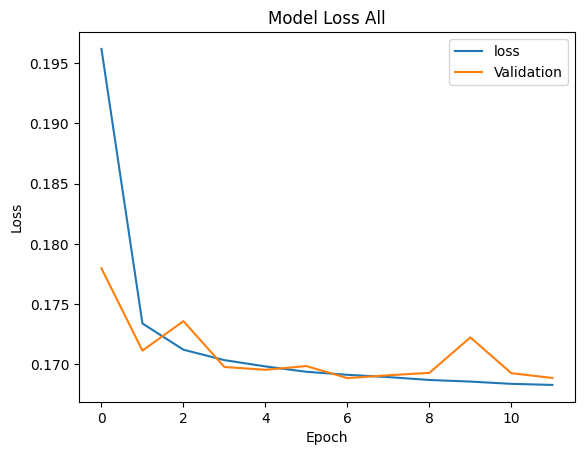

In [23]:
# Plot the training and validation loss
plt.plot(myhistory_all.history['loss'])
plt.plot(myhistory_all.history['val_loss'])
plt.title('Model Loss All')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'Validation'], loc='upper right')
plt.show()

In [129]:
preds_all_BCE = model_all.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
fpr_all_BCE, tpr_all_BCE, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_BCE)

100/100 [==============================] - 0s 690us/step


In [5]:
#model_all_BCE = tf.keras.models.load_model("model_all_ordered_BCE")
#model_all_MSE = tf.keras.models.load_model("model_all_MSE_3_4096")

In [102]:
#preds_all_MSE = model_all_MSE.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
#fpr_all_MSE, tpr_all_MSE, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_MSE)

99/99 [==============================] - 0s 2ms/step


In [130]:
preds_100_BCE = model_dedicated.predict(X_val_100,batch_size=1000)
fpr_100_BCE, tpr_100_BCE, _ = metrics.roc_curve(Y_val_100, preds_100_BCE)

99/99 [==============================] - 0s 675us/step


/tmp/ipykernel_808700/2993218434.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_100_BCE,1./(fpr_100_BCE),label="dedicated_100")
/tmp/ipykernel_808700/2993218434.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE,1./(fpr_all_BCE),label="parameterized_100")


Text(0.5, 1.0, '$(m_B,m_C) = (100,100)$ GeV Dedicated BCE vs Parametrized BCE (Optimized)')

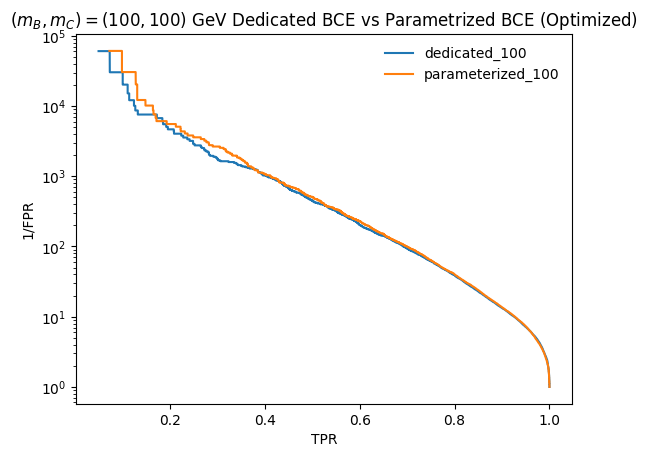

In [131]:
epsilon = 1e-6
plt.plot(tpr_100_BCE,1./(fpr_100_BCE),label="dedicated_100")
plt.plot(tpr_all_BCE,1./(fpr_all_BCE),label="parameterized_100")

plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_B,m_C) = (100,100)$ GeV Dedicated BCE vs Parametrized BCE (Optimized)")

In [82]:
#freezes the layers of the model (i.e all trainable params)
for l in model_all.layers:
    l.trainable=False

model3 = createSimpleModel(2.)
model32 = createSimpleModel(3.)

#create final model with everything combined
inputs = tf.keras.Input(shape=(4,))
concatenated_inputs = tf.keras.layers.concatenate([inputs, model3(tf.ones_like(inputs)[:,0]), model32(tf.ones_like(inputs)[:,0])])
hidden_layer_1 = model_all_BCE(concatenated_inputs)
model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

In [24]:
model_all2.trainable_weights

[<tf.Variable 'dense_8/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[2.]], dtype=float32)>,
 <tf.Variable 'dense_9/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[3.]], dtype=float32)>]

In [83]:
myhistory_all2 = model_all2.fit(x_vals_100[:,0:4], y_vals_100, epochs=10,validation_data=(X_val_100[:,0:4], Y_val_100),batch_size=1024)

Epoch 1/10
193/193 [==============================] - 1s 3ms/step - loss: 3.0335 - val_loss: 2.8581
Epoch 2/10
193/193 [==============================] - 0s 2ms/step - loss: 2.7964 - val_loss: 2.7314
Epoch 3/10
193/193 [==============================] - 0s 2ms/step - loss: 2.7099 - val_loss: 2.6704
Epoch 4/10
193/193 [==============================] - 0s 2ms/step - loss: 2.6482 - val_loss: 2.6068
Epoch 5/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5891 - val_loss: 2.5549
Epoch 6/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5492 - val_loss: 2.5264
Epoch 7/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5264 - val_loss: 2.5062
Epoch 8/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5055 - val_loss: 2.4842
Epoch 9/10
193/193 [==============================] - 0s 2ms/step - loss: 2.4825 - val_loss: 2.4604
Epoch 10/10
193/193 [==============================] - 0s 2ms/step - loss: 2.4584 - val_loss: 2.4398

In [11]:
model_all = tf.keras.models.load_model("model_all_BCE")
#model_all_MSE = tf.keras.models.load_model("model_all_MSE_3_4096")

In [21]:
xx = []
mm = []
for m1 in mass_range[1:]:
        for m2 in mass_range[1:]:

            #freeze layers
            for l in model_all.layers:
                l.trainable=False

            #create simple models
            model3 = createSimpleModel(1)
            model32 = createSimpleModel(4)

            #combine everything
            inputs = tf.keras.Input(shape=(4,))
            inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
            hidden_layer_1 = model_all(inputs2)
            model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
            model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

            x_vals_ = np.concatenate([x[0,0],x[m1,m2]])
            y_vals_ = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[m1,m2]))])
            X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)
            myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)
            print(m1,m2,np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1])
            xx += [[np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1]]]
            mm += [[m1,m2]]

In [95]:
xx = np.array(xx)
mm = np.array(mm)

found_both = 0.
found_one = 0.
found_none = 0.
for i in range(len(mm)):
    diff1 = abs(mm[i][0]-xx[i][0])
    diff2 = abs(mm[i][1]-xx[i][0])
    diff3 = abs(mm[i][0]-xx[i][1])
    diff4 = abs(mm[i][1]-xx[i][1])
    diffs = [diff1,diff2,diff3,diff4]
    if (diff1 < 0.2 and diff4 < 0.2) or (diff2 < 0.2 and diff3 < 0.2):
        #print(mm[i],xx[i])
        found_both+=1
    elif (min(diffs) < 0.2):
        print(mm[i],xx[i])
        found_one+=1
        pass
    else:
        print(mm[i],xx[i])
        found_none+=1
        pass

print("found both:",found_both/(found_both+found_one+found_none))
print("found one:",found_one/(found_both+found_one+found_none))
print("found none:",found_none/(found_both+found_one+found_none))

[0.5 0.5] [ 0.52852035 10.807516  ]
[0.5 1. ] [1.1410923 8.681716 ]
[0.5 1.5] [1.7087789 9.502621 ]
[0.5 2. ] [2.209993 9.610666]
[0.5 2.5] [2.634493  2.4807847]
[1.  0.5] [1.1314318 8.826323 ]
[1. 1.] [1.0516274 8.336853 ]
[1.  1.5] [1.5585779 8.746403 ]
[1. 2.] [2.1806989 9.658493 ]
[1.  2.5] [2.613276  2.4700634]
[1.5 0.5] [1.714507 9.539725]
[1.5 1. ] [1.5685513 8.818821 ]
[2.  0.5] [2.1968632 9.525651 ]
[2. 1.] [2.1850243 9.7158575]
[2.5 0.5] [2.6377742 2.5102966]
[2.5 1. ] [2.6152718 2.4667516]
[3.  0.5] [3.2449262 3.019374 ]
[5.5 0.5] [0.2262814 5.619852 ]
[6.  0.5] [6.015816  6.1012135]
found both: 0.8680555555555556
found one: 0.1111111111111111
found none: 0.020833333333333332


In [22]:
m1_list = np.unique(x_vals_all[:, -2])
m2_list = np.unique(x_vals_all[:, -1])

In [38]:
m1_list == np.array(mass_range[1:])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [139]:
sig_list

[0.001,
 0.0012742749857031334,
 0.001623776739188721,
 0.00206913808111479,
 0.0026366508987303583,
 0.003359818286283781,
 0.004281332398719396,
 0.00545559478116852,
 0.0069519279617756054,
 0.008858667904100823,
 0.011288378916846888,
 0.01438449888287663,
 0.018329807108324356,
 0.023357214690901212,
 0.029763514416313176,
 0.0379269019073225,
 0.04832930238571752,
 0.06158482110660261,
 0.07847599703514611,
 0.1]

In [43]:
np.shape(x[0,0])

(121352, 4)

3.241 3.649 0.001
30338 91014 30 0.0009888588568791614
Epoch 1/50
30/30 [==============================] - 1s 16ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 6ms/st

/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 11ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 11/50
30/30 [==========

/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 10ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 11/50
30/30 [==========

/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 11ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 11/50
30/30 [==========

/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 13ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 11/50
30/30 [==========

/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 13ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 11/50
30/30 [==========

/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 11ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 11/50
30/30 [==========

/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 12ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 11/50
30/30 [==========

/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 11ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6934
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 5/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 6/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 11/50
30/30 [==========

/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 11ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 5/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 6/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 11/50
30/30 [=========

/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 11ms/step - loss: 0.6933 - val_loss: 0.6935
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6933 - val_loss: 0.6934
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6933 - val_loss: 0.6934
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6934
Epoch 5/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6934
Epoch 6/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 11/50
30/30 [==========

/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 10ms/step - loss: 0.6935 - val_loss: 0.6934
Epoch 2/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6935 - val_loss: 0.6934
Epoch 3/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6934 - val_loss: 0.6934
Epoch 4/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6934 - val_loss: 0.6934
Epoch 5/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6934 - val_loss: 0.6934
Epoch 6/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 7/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 10/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6928 - val_loss: 0.6930
Epoch 11/50
30/30 [==========

/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 2s 12ms/step - loss: 0.6935 - val_loss: 0.6936
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6935 - val_loss: 0.6936
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6934 - val_loss: 0.6935
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6934 - val_loss: 0.6934
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 6/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6926 - val_loss: 0.6928
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6923 - val_loss: 0.6926
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6921 - val_loss: 0.6922
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6918 - val_loss: 0.6918
Epoch 11/50
30/30 [=========

/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 10ms/step - loss: 0.6936 - val_loss: 0.6938
Epoch 2/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6935 - val_loss: 0.6938
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6934 - val_loss: 0.6937
Epoch 4/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6933 - val_loss: 0.6936
Epoch 5/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6932 - val_loss: 0.6934
Epoch 6/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6928 - val_loss: 0.6929
Epoch 8/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6925 - val_loss: 0.6925
Epoch 9/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6922 - val_loss: 0.6919
Epoch 10/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6918 - val_loss: 0.6909
Epoch 11/50
30/30 [==========

/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 11ms/step - loss: 0.6939 - val_loss: 0.6940
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6938 - val_loss: 0.6940
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6937 - val_loss: 0.6939
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6935 - val_loss: 0.6937
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 6/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6928 - val_loss: 0.6929
Epoch 7/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6920 - val_loss: 0.6921
Epoch 8/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6911 - val_loss: 0.6909
Epoch 9/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6898 - val_loss: 0.6893
Epoch 10/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6890 - val_loss: 0.6889
Epoch 11/50
31/31 [==========

/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 10ms/step - loss: 0.6939 - val_loss: 0.6945
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6937 - val_loss: 0.6942
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6933 - val_loss: 0.6938
Epoch 4/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6928 - val_loss: 0.6932
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6921 - val_loss: 0.6925
Epoch 6/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6912 - val_loss: 0.6908
Epoch 7/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6894 - val_loss: 0.6883
Epoch 8/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6878 - val_loss: 0.6870
Epoch 9/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6875 - val_loss: 0.6870
Epoch 10/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6875 - val_loss: 0.6871
Epoch 11/50
31/31 [==========

/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 10ms/step - loss: 0.6944 - val_loss: 0.6949
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6942 - val_loss: 0.6947
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6938 - val_loss: 0.6942
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6916 - val_loss: 0.6913
Epoch 6/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6893 - val_loss: 0.6879
Epoch 7/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6863 - val_loss: 0.6852
Epoch 8/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6854 - val_loss: 0.6851
Epoch 9/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6854 - val_loss: 0.6852
Epoch 10/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6854 - val_loss: 0.6851
Epoch 11/50
31/31 [==========

/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 10ms/step - loss: 0.6949 - val_loss: 0.6956
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6945 - val_loss: 0.6952
Epoch 3/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6938 - val_loss: 0.6942
Epoch 4/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6926 - val_loss: 0.6924
Epoch 5/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6899 - val_loss: 0.6885
Epoch 6/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6850 - val_loss: 0.6831
Epoch 7/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6828 - val_loss: 0.6829
Epoch 8/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6827 - val_loss: 0.6829
Epoch 9/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6827 - val_loss: 0.6828
Epoch 10/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6828 - val_loss: 0.6829
Epoch 11/50
31/31 [==========

/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 12ms/step - loss: 0.6958 - val_loss: 0.6963
Epoch 2/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6950 - val_loss: 0.6950
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6933 - val_loss: 0.6923
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6893 - val_loss: 0.6868
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6825 - val_loss: 0.6798
Epoch 6/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6791 - val_loss: 0.6797
Epoch 7/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6791 - val_loss: 0.6797
Epoch 8/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6791 - val_loss: 0.6797
Epoch 9/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6791 - val_loss: 0.6797
Epoch 10/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6791 - val_loss: 0.6797
Epoch 11/50
31/31 [==========

/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


32/32 [==============================] - 2s 11ms/step - loss: 0.6967 - val_loss: 0.6967
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.6946 - val_loss: 0.6933
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.6903 - val_loss: 0.6878
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.6829 - val_loss: 0.6784
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.6757 - val_loss: 0.6754
Epoch 6/50
32/32 [==============================] - 0s 6ms/step - loss: 0.6748 - val_loss: 0.6754
Epoch 7/50
32/32 [==============================] - 0s 6ms/step - loss: 0.6748 - val_loss: 0.6754
Epoch 8/50
32/32 [==============================] - 0s 5ms/step - loss: 0.6748 - val_loss: 0.6754
Epoch 9/50
32/32 [==============================] - 0s 5ms/step - loss: 0.6748 - val_loss: 0.6754
Epoch 10/50
32/32 [==============================] - 0s 6ms/step - loss: 0.6748 - val_loss: 0.6754
Epoch 11/50
32/32 [==========

/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:86: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/1023129900.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


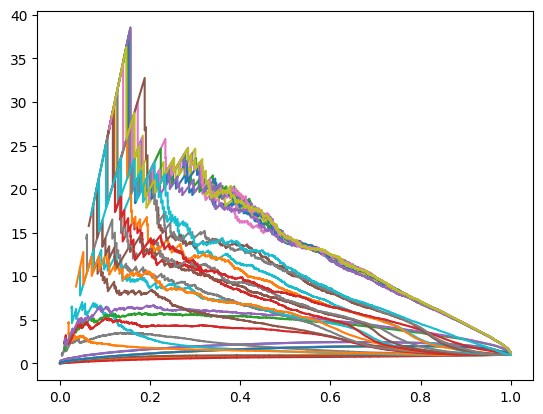

In [20]:
xx = []
yy = []
zz = []
ww = []

msic1 = []
msic2 = []
epsilon = 1e-6

# w1 = round(random.uniform(0.5, 6.0),3)
# w2 = round(random.uniform(0.5, 6.0),3)

w1 = 3.241
w2 = 3.649

for sigfrac in np.logspace(-3,-1,20):
    print(w1, w2, sigfrac)
    #sigfrac = 0.05
    if (sigfrac > 0.5):
        continue

    for l in model_all.layers:
        l.trainable=False

    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)
    
    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
    LLR_xs = 1.+sigfrac*LLR - sigfrac
    #LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
    backtoprob = LLR_xs / (1.+LLR_xs)
    model_all2 = Model(inputs = inputs, outputs = backtoprob)
    model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

    m1 = 2
    m2 = 4.5

    test_set_back = int(len(x[0,0])*0.5)
    train_set_reference = int(len(x[0,0])*0.25)
    train_set_data = len(x[0,0]) - test_set_back - train_set_reference
    test_set_sig = int(len(x[m1,m2])*0.5)
    sig_frac = sigfrac

    tot = train_set_reference
    x_vals_ = np.concatenate([x[0,0][test_set_back:],x[m1,m2][test_set_sig:test_set_sig+int(sig_frac*tot)]])
    y_vals_ = np.concatenate([np.zeros(train_set_reference),np.ones(train_set_data),np.ones(len(x[m1,m2][test_set_sig:test_set_sig+int(sig_frac*tot)]))])

    print(tot,len(x[0,0])-tot,len(x[m1,m2][0:int(sig_frac*tot)]),len(x[m1,m2][0:int(sig_frac*tot)])/tot)

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5, random_state = 42)
    
    myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=50,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
    xx+=[sigfrac]
    yy+=[model_all2.trainable_weights[0].numpy()[0][0]]
    zz+=[model_all2.trainable_weights[1].numpy()[0][0]]
    #ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
    scores = model_all2.predict(np.concatenate([x[0,0][0:test_set_back],x[m1,m2][0:test_set_sig]]),batch_size=1024)
    y = np.concatenate([np.zeros(test_set_back),np.ones(test_set_sig)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)    
    
    #Now, let's do weakly supervised learning.
    model_cwola = Sequential()
    model_cwola.add(Dense(128, input_dim=4, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    
    scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_set_back],x[m1,m2][0:test_set_sig]]),batch_size=1024)
    y2 = np.concatenate([np.zeros(test_set_back),np.ones(test_set_sig)])
    fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
    plt.plot(tpr,tpr/np.sqrt(fpr))
    plt.plot(tpr2,tpr2/np.sqrt(fpr2))
    
    msic1+=[np.max(tpr/np.sqrt(fpr+0.0001))]
    msic2+=[np.max(tpr2/np.sqrt(fpr2+0.0001))]

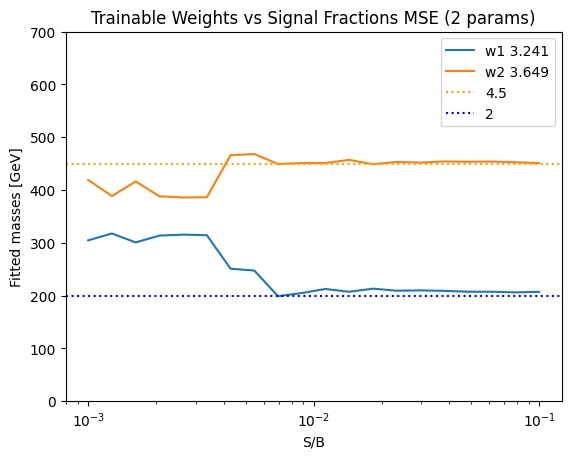

In [21]:
plt.plot(xx,np.array(yy)*100, label = f"w1 {w1}")
plt.plot(xx,np.array(zz)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions MSE (2 params)")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])
plt.show()

Text(0, 0.5, 'max SIC')

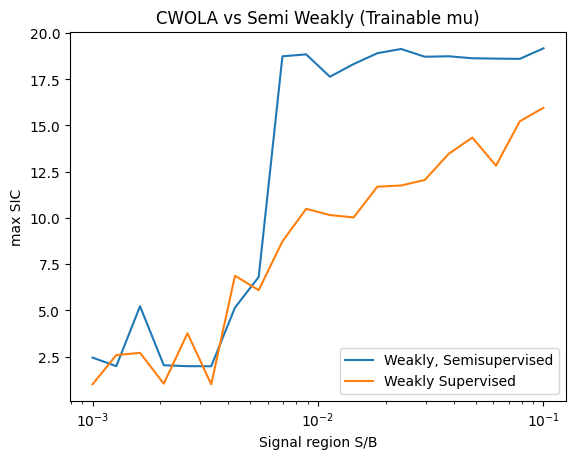

In [18]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (Trainable mu)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")

Text(0, 0.5, 'Fitted S/B')

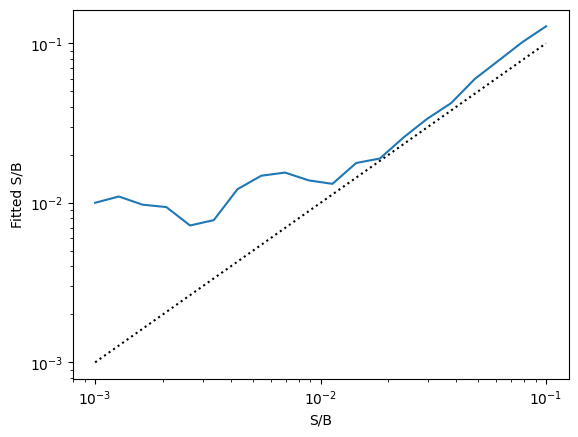

In [15]:
plt.plot(xx,np.array(ww))
plt.xscale("log")
plt.yscale("log")
plt.plot(xx,xx,ls=":",color="black")
plt.xlabel("S/B")
plt.ylabel("Fitted S/B")

Text(0, 0.5, 'max SIC')

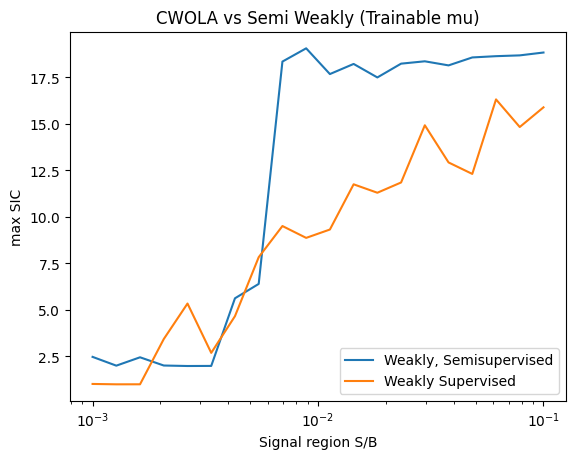

In [22]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (Trainable mu)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")

Text(0, 0.5, 'max SIC')

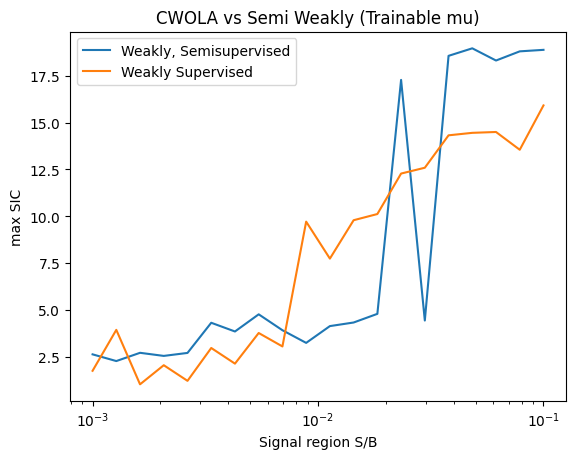

In [56]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (Trainable mu)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")

Text(0, 0.5, 'max SIC')

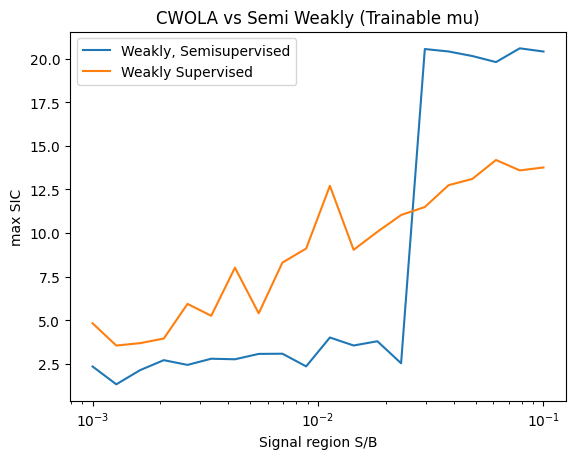

In [115]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (Trainable mu)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")

In [ ]:
num_runs = 5
scores_list_runs = []

msic1_list_runs = []
msic2_list_runs = []

for _ in range(num_runs):

    xx = []
    yy = []
    zz = []
    ww = []

    msic1 = []
    msic2 = []
    
    score_list = []
    
#     initial_learning_rate = 0.05 #placeholder till callback

#     lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#         initial_learning_rate, decay_steps=30*3, decay_rate=0.8, staircase=True
#     )

    w1 = round(random.uniform(0.5, 6.0),3)
    w2 = round(random.uniform(0.5, 6.0),3)
    
    for sigfrac in np.logspace(-3,-1,20):
        print(w1, w2, sigfrac)
        #sigfrac = 0.05
        if (sigfrac > 0.5):
            continue

        for l in model_all.layers:
            l.trainable=False

        inputs_hold = tf.keras.Input(shape=(1,))
        simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
        model3 = Model(inputs = inputs_hold, outputs = simple_model)

        inputs_hold2 = tf.keras.Input(shape=(1,))
        simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
        model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

        inputs_hold3 = tf.keras.Input(shape=(1,))
        simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
        model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

        inputs = tf.keras.Input(shape=(4,))
        inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
        hidden_layer_1 = model_all(inputs2)
        LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
        LLR_xs = 1.+sigfrac*LLR - sigfrac
        #LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
        backtoprob = LLR_xs / (1.+LLR_xs)
        model_all2 = Model(inputs = inputs, outputs = backtoprob)
        model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

        m1 = 3
        m2 = 4.5

        test_set_back = int(len(x[0,0])*0.5)
        train_set_reference = int(len(x[0,0])*0.25)
        train_set_data = len(x[0,0]) - test_set_back - train_set_reference
        test_set_sig = int(len(x[m1,m2])*0.5)
        sig_frac = sigfrac

        tot = train_set_reference
        x_vals_ = np.concatenate([x[0,0][test_set_back:],x[m1,m2][test_set_sig:test_set_sig+int(sig_frac*tot)]])
        y_vals_ = np.concatenate([np.zeros(train_set_reference),np.ones(train_set_data),np.ones(len(x[m1,m2][test_set_sig:test_set_sig+int(sig_frac*tot)]))])

        print(tot,len(x[0,0])-tot,len(x[m1,m2][0:int(sig_frac*tot)]),len(x[m1,m2][0:int(sig_frac*tot)])/tot)

        X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5, random_state = 42)

        myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=50,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
        print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
        xx+=[sigfrac]
        yy+=[model_all2.trainable_weights[0].numpy()[0][0]]
        zz+=[model_all2.trainable_weights[1].numpy()[0][0]]
        #ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
        scores = model_all2.predict(np.concatenate([x[0,0][0:test_set_back],x[m1,m2][0:test_set_sig]]),batch_size=1024)
        y = np.concatenate([np.zeros(test_set_back),np.ones(test_set_sig)])
        fpr, tpr, _ = metrics.roc_curve(y, scores)
        
        score_list.append(scores)

        model_cwola = Sequential()
        model_cwola.add(Dense(128, input_dim=4, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(1, activation='sigmoid'))
        model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)

        scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_set_back],x[m1,m2][0:test_set_sig]]),batch_size=1024)
        y2 = np.concatenate([np.zeros(test_set_back),np.ones(test_set_sig)])
        fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
        plt.plot(tpr,tpr/np.sqrt(fpr))
        plt.plot(tpr2,tpr2/np.sqrt(fpr2))

        msic1+=[np.max(tpr/np.sqrt(fpr+0.0001))]
        msic2+=[np.max(tpr2/np.sqrt(fpr2+0.0001))]
        
    msic1_list_runs.append(msic1)
    msic2_list_runs.append(msic2)
    scores_list_runs.append(score_list)

3.387 5.631 0.001
30338 91014 30 0.0009888588568791614
Epoch 1/50
30/30 [==============================] - 1s 14ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 6ms/st

/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 11/50
30/30 [==========

/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 11/50
30/30 [==========

/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 11/50
30/30 [==========

/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 6/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 11/50
30/30 [=========

/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 5/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 6/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 9/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 11/50
30/30 [==========

/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 10ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 3/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 5/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 6/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 8/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 11/50
30/30 [==========

/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6933
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6933
Epoch 5/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6933
Epoch 6/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6933
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6933
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6933
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6933
Epoch 10/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6930 - val_loss: 0.6933
Epoch 11/50
30/30 [=========

/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 3s 67ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 11/50
30/30 [==========

/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 12ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - val_loss: 0.6931
Epoch 6/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 14ms/step - loss: 0.6929 - val_loss: 0.6931
Epoch 8/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6929 - val_loss: 0.6931
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - val_loss: 0.6931
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6928 - val_loss: 0.6931
Epoch 11/50
30/30 [=========

/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 342 0.011272990968422441
Epoch 1/50
30/30 [==============================] - 1s 15ms/step - loss: 0.6929 - val_loss: 0.6933
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6927 - val_loss: 0.6931
Epoch 4/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6926 - val_loss: 0.6931
Epoch 5/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6926 - val_loss: 0.6930
Epoch 6/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6926 - val_loss: 0.6928
Epoch 7/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6925 - val_loss: 0.6925
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6923 - val_loss: 0.6921
Epoch 9/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6920 - val_loss: 0.6918
Epoch 10/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6918 

/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 18ms/step - loss: 0.6929 - val_loss: 0.6931
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6926 - val_loss: 0.6929
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6925 - val_loss: 0.6928
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6923 - val_loss: 0.6924
Epoch 5/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6918 - val_loss: 0.6918
Epoch 6/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6912 - val_loss: 0.6913
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6908 - val_loss: 0.6913
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6908 - val_loss: 0.6913
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6908 - val_loss: 0.6913
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6908 - val_loss: 0.6913
Epoch 11/50
30/30 [==========

/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 14ms/step - loss: 0.6927 - val_loss: 0.6930
Epoch 2/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6923 - val_loss: 0.6926
Epoch 3/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6921 - val_loss: 0.6921
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6917 - val_loss: 0.6916
Epoch 5/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6911 - val_loss: 0.6908
Epoch 6/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6905 - val_loss: 0.6904
Epoch 7/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6903 - val_loss: 0.6904
Epoch 8/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6902 - val_loss: 0.6904
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6902 - val_loss: 0.6904
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6902 - val_loss: 0.6904
Epoch 11/50
30/30 [==========

/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


Epoch 1/50
30/30 [==============================] - 1s 11ms/step - loss: 0.6926 - val_loss: 0.6925
Epoch 2/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6918 - val_loss: 0.6915
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6908 - val_loss: 0.6903
Epoch 4/50
30/30 [==============================] - 1s 18ms/step - loss: 0.6898 - val_loss: 0.6897
Epoch 5/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6893 - val_loss: 0.6896
Epoch 6/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6893 - val_loss: 0.6896
Epoch 7/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6893 - val_loss: 0.6896
Epoch 8/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6893 - val_loss: 0.6896
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6893 - val_loss: 0.6895
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6893 - val_loss: 0.6895
Epoch 11/50
30/30

/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 11ms/step - loss: 0.6920 - val_loss: 0.6917
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6907 - val_loss: 0.6904
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6895 - val_loss: 0.6891
Epoch 4/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6885 - val_loss: 0.6884
Epoch 5/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6881 - val_loss: 0.6883
Epoch 6/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6881 - val_loss: 0.6883
Epoch 7/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6881 - val_loss: 0.6883
Epoch 8/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6881 - val_loss: 0.6883
Epoch 9/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6881 - val_loss: 0.6883
Epoch 10/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6881 - val_loss: 0.6883
Epoch 11/50
31/31 [==========

/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 10ms/step - loss: 0.6910 - val_loss: 0.6908
Epoch 2/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6892 - val_loss: 0.6889
Epoch 3/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6875 - val_loss: 0.6874
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6866 - val_loss: 0.6869
Epoch 5/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6864 - val_loss: 0.6869
Epoch 6/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6864 - val_loss: 0.6869
Epoch 7/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6864 - val_loss: 0.6870
Epoch 8/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6864 - val_loss: 0.6869
Epoch 9/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6864 - val_loss: 0.6869
Epoch 10/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6864 - val_loss: 0.6869
Epoch 11/50
31/31 [==========

/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 10ms/step - loss: 0.6908 - val_loss: 0.6895
Epoch 2/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6880 - val_loss: 0.6872
Epoch 3/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6857 - val_loss: 0.6853
Epoch 4/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6844 - val_loss: 0.6848
Epoch 5/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6841 - val_loss: 0.6848
Epoch 6/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6841 - val_loss: 0.6848
Epoch 7/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6841 - val_loss: 0.6848
Epoch 8/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6841 - val_loss: 0.6848
Epoch 9/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6841 - val_loss: 0.6848
Epoch 10/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6841 - val_loss: 0.6848
Epoch 11/50
31/31 [=========

/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 10ms/step - loss: 0.6895 - val_loss: 0.6874
Epoch 2/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6855 - val_loss: 0.6846
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.6828 - val_loss: 0.6826
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6814 - val_loss: 0.6822
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6812 - val_loss: 0.6823
Epoch 6/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6812 - val_loss: 0.6822
Epoch 7/50
31/31 [==============================] - 0s 7ms/step - loss: 0.6811 - val_loss: 0.6822
Epoch 8/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6812 - val_loss: 0.6822
Epoch 9/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6812 - val_loss: 0.6822
Epoch 10/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6812 - val_loss: 0.6822
Epoch 11/50
31/31 [==========

/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:99: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2254175/58563329.py:100: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 10ms/step - loss: 0.6876 - val_loss: 0.6853
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6828 - val_loss: 0.6815
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6799 - val_loss: 0.6788
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6783 - val_loss: 0.6782
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.6781 - val_loss: 0.6782
Epoch 6/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6780 - val_loss: 0.6782
Epoch 7/50
31/31 [==============================] - 0s 7ms/step - loss: 0.6780 - val_loss: 0.6782
Epoch 8/50
31/31 [==============================] - 0s 6ms/step - loss: 0.6780 - val_loss: 0.6782
Epoch 9/50
31/31 [==============================] - 0s 7ms/step - loss: 0.6780 - val_loss: 0.6782
Epoch 10/50
31/31 [==============================] - 0s 7ms/step - loss: 0.6780 - val_loss: 0.6782
Epoch 11/50
31/31 [=========

In [33]:
np.shape(score_list)

(20, 97071, 1)

/tmp/ipykernel_2254175/1089124578.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_2254175/1089124578.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_2254175/1089124578.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_2254175/1089124578.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_2254175/1089124578.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_2254175/1089124578.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_2254175/1089124578.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_2254175/1089124578.py:

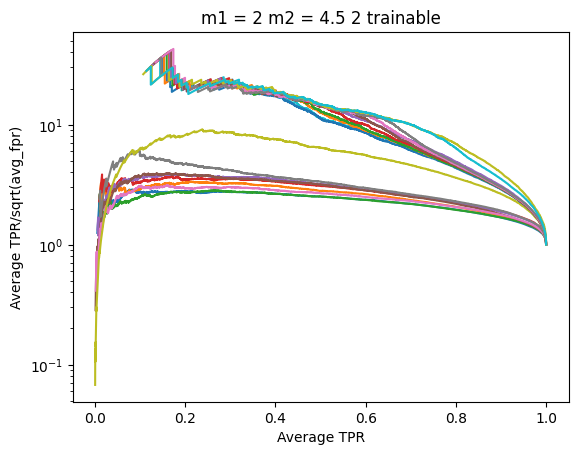

In [35]:
avg = np.mean(scores_list_runs, axis = 0)
for avg_scores in avg:
    avg_fpr, avg_tpr, _ = metrics.roc_curve(y, avg_scores)
    plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
    plt.title(f"m1 = {m1} m2 = {m2} 2 trainable")
    plt.xlabel("Average TPR")
    plt.ylabel("Average TPR/sqrt(avg_fpr)")
plt.yscale("log")

Text(0, 0.5, 'Avg Max SIC')

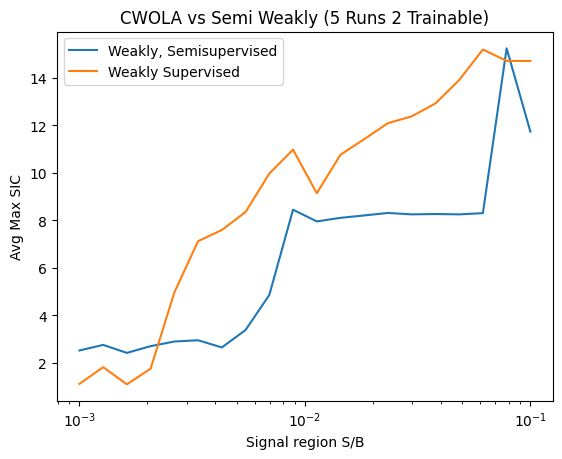

In [36]:
avgmsic1 = np.mean(msic1_list_runs, axis = 0)
avgmsic2 = np.mean(msic2_list_runs, axis = 0)

plt.plot(xx,avgmsic1,label="Weakly, Semisupervised")
plt.plot(xx,avgmsic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (5 Runs 2 Trainable)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")